In [1]:
# A file for Testing PyFBS features:
# load package
import pyFBS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


LOAD IN YOUR EXP DATA FROM BK CONNECT BELOW -  WRITE THE RIGHT FILENAME - If you did not call it DATA_A - then rename

In [2]:

df = pd.read_excel('./datafiles/DATA_A.xlsx', engine='openpyxl',nrows=4002)

###################################################################################
# Drop the first column
df = df.iloc[:, 1:]

# Initialize an empty list to store complex numbers
complex_data = []

# Iterate over the columns in pairs (real and imaginary)
for i in range(0, df.shape[1], 2):
    real_part = df.iloc[:4001, i]
    imag_part = df.iloc[:4001, i + 1]
    complex_column = real_part + 1j * imag_part
    complex_data.append(complex_column)

# Convert the list to a NumPy array and reshape it to (4001, 225)
complex_array = np.array(complex_data).T

# Reshape the array to (4001, 15, 15)
YA_mea_long = complex_array.reshape(4001, 15, 15, order='F')
YA_mea=YA_mea_long[::2,:,:]

# Print the shape of the reshaped array to verify
print(YA_mea.shape) # You should have 1 Hz resolution and measurements up to 2000 Hz

(2001, 15, 15)


Now we load in the numerical model of substructure A and try to define the same sensor and impact positions:

In [3]:
# Load in mass and stiffness of Ansysis model
MK_A = pyFBS.MK_model(r"./datafiles/A.rst", r"./datafiles/A.full",allow_pickle=True,scale=1000) 

#define numerical positions

## THIS EXCEL SHEET HOLDS YOUR MEASURE POSITIONS && THE POSITION OF YOUR VP
path1 = r'./datafiles/geo_pos_dir_MONDAY.xlsx' # location of your excel sheet

#A in meters - call the positions of channels and impacts. The "Sensors" are only for visualsing the gray box
df_acc_A = pd.read_excel(path1, sheet_name='Sensors_A')
df_chn_A = pd.read_excel(path1, sheet_name='Channels_A')
df_imp_A = pd.read_excel(path1, sheet_name='Impacts_A')

#in milimeters and updated to an actual position on the MK mesh
df_chn_A_up = MK_A.update_locations_df(df_chn_A,scale = 1000)
df_imp_A_up = MK_A.update_locations_df(df_imp_A,scale = 1000)

MK_A.FRF_synth(df_chn_A_up,df_imp_A_up,f_start=0,f_end=2001, limit_modes=100, modal_damping=0.003, frf_type="accelerance")




Now we plot the defined sensors and impacts on the structure 

In [4]:
# FBS EXP A SETUP PHD COURSE 
path_stl_A = r"./datafiles/A_free.stl" # the geometry
view3D = pyFBS.view3D(show_origin = False, show_axes = False,shape =  (1,1),title = "Overview A")
view3D.plot.isometric_view()
view3D.plot.add_text("A VPT", position='upper_left', font_size=10, color="k", font="times", name="A_structure");
view3D.add_stl(path_stl_A,color = "#83afd2", opacity = 1,name = "A VPT");
view3D.show_acc(df_acc_A,scale=1000)
view3D.show_imp(df_imp_A,scale=1000, size=25,color="r", overwrite=False)
view3D.show_chn(df_chn_A,scale=1000)
view3D.label_chn(df_chn_A,scale=1000,font_size = 15)
view3D.label_acc(df_acc_A,scale=1000,font_size = 25)
view3D.label_imp(df_imp_A,scale=1000,font_size = 20)

Do the positions and directions in the 3D figure match with the actual experiment?

Now we will qualitively compare the numerical predictions and your experimental data? How do they match? Do you expect them to be perfect? Or does it make sense if they are slighty different? How does your experimental data look - noisy/rippled or smooth ?

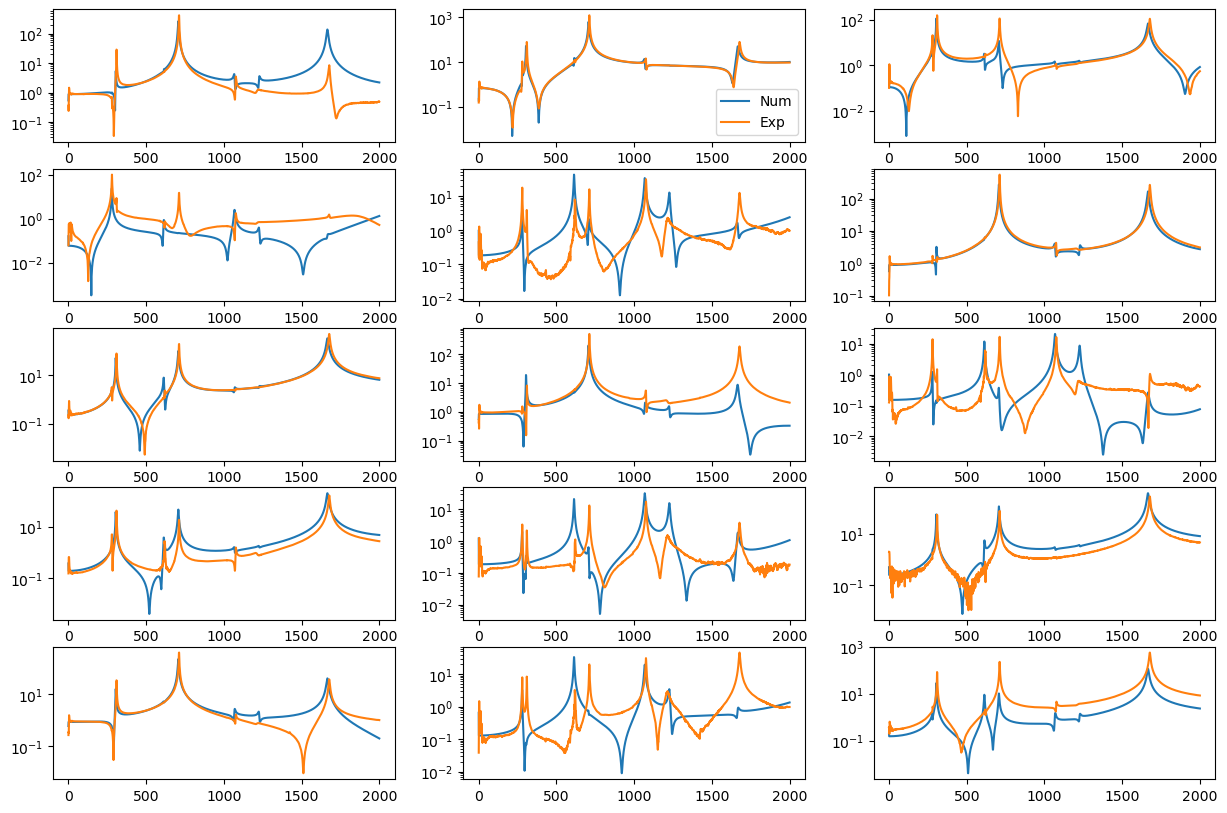

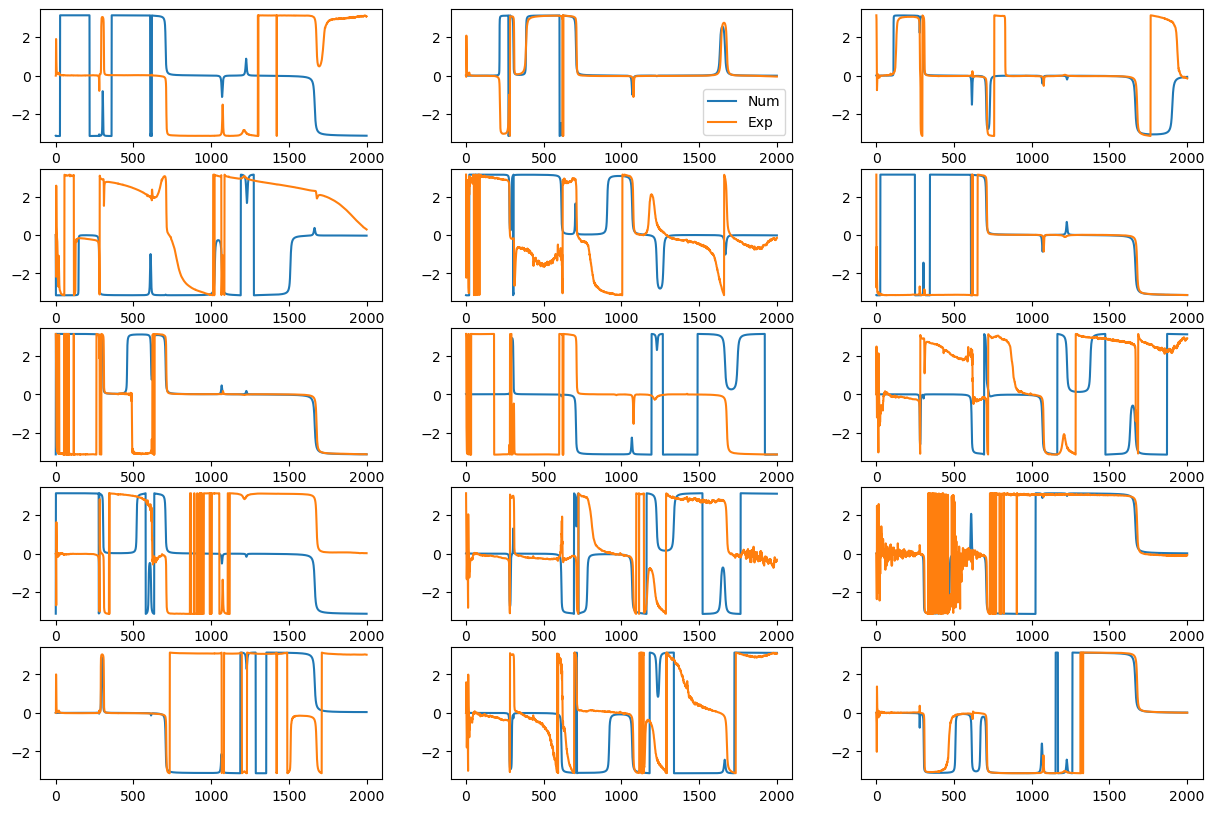

In [7]:
imp_n= 3 # impact number - starts from 1 - change the number to see response for different impacts
freq=np.linspace(0,2000,2001)

# Gain PLot
for i in range(15):
    plt.figure(1, figsize=(15,10))
    if i==2:
        plt.legend(['Num','Exp'],loc="lower right")
    plt.subplot(5,3,i+1)
    plt.semilogy(freq,abs(MK_A.FRF[:,i-1,imp_n-1])) # PLOT EXP REFERENCE OF ASSEMBLED SYSTEM
    plt.semilogy(freq,abs(YA_mea[:,i-1,+imp_n-1])) # PLOT NUMERICAL FBS COUPLED
    

# Phase Plot
for i in range(15):
    plt.figure(2, figsize=(15,10))
    if i==2:
        plt.legend(['Num','Exp'],loc="lower right")
    plt.subplot(5,3,i+1)
    plt.plot(freq,np.angle(MK_A.FRF[:,i-1,+imp_n-1])) # PLOT EXP REFERENCE OF ASSEMBLED SYSTEM
    plt.plot(freq,np.angle(YA_mea[:,i-1,+imp_n-1])) # PLOT NUMERICAL FBS COUPLED

We can also quantify the how alike experiment and data is by calculating the coherence:

In [6]:
# Compute cross-spectrum
cross_spectrum = np.mean(MK_A.FRF * np.conj(YA_mea), axis=0)

# Compute power spectra
power_spectrum_1 = np.mean(np.abs(MK_A.FRF)**2, axis=0)
power_spectrum_2 = np.mean(np.abs(YA_mea)**2, axis=0)

# Compute coherence
coherence = np.transpose(np.abs(cross_spectrum)**2 / (power_spectrum_1 * power_spectrum_2))

pyFBS.imshow(coherence)



alt.Chart(...)